# Importation des données

In [1]:
import pandas as pd

import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import zscore
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("dataset_insurance.csv")

In [3]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
df['sex'].value_counts()

sex
male      676
female    662
Name: count, dtype: int64

In [7]:
df[['sex','smoker']].value_counts()

sex     smoker
female  no        547
male    no        517
        yes       159
female  yes       115
Name: count, dtype: int64

- **Indice de masse corporel (BMI)** : Permet de donner un rapport entre la taille et le poids. Idéalement, il faut être entre 18.5 et 24.9.
- **Sexe (Sex)** : Genre de la personne qui contracte l’assurance (homme ou femme).
- **Âge (Age)** : Âge du principal bénéficiaire.
- **Nombre d’enfants à charge (Children)** : Nombre d’enfants couverts par l’assurance.
- **Fumeur (Smoker)** : Fumeur ou non-fumeur.
- **Région (Region)** : Zone résidentielle dans les États-Unis (Nord-Est, Sud-Est, Sud-Ouest, Nord-Ouest).
- **Charges (Charges)** : La prime d’assurance facturée (cible).

# Partie Analyse

1. **Vérifiez les informations manquantes et les doublons** (outil : `missingno`).
2. **Détection des valeurs aberrantes.**
3. **Analyse univariée :** Analysez chaque variable indépendamment.
4. **Corrélation des variables :** Étudiez les corrélations avec la variable cible.
5. **Analyse bivariée :** Exemple : interaction entre sexe et fumeur.
6. **Visualisations graphiques :**
    - Utilisez des box plots ou violin plots (outil : `seaborn`).
7. **Validation des hypothèses :** Utilisez des tests statistiques.
8. **Visualisations :** Appuyez chaque point par des graphiques pertinents.

## 1 | Vérification des doublons & informations manquantes


In [8]:
## Valeurs dupliquées / Doublons

df.duplicated().sum()

np.int64(1)

In [9]:
doublons = df[df.duplicated(keep=False)]
print(doublons)

""" Il y a en effet une ligne en doublon, nous allons dans ce cas la supprimer (peu importe 1ère(first) ou 2nd itération(last))"""

     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631


' Il y a en effet une ligne en doublon, nous allons dans ce cas la supprimer (peu importe 1ère(first) ou 2nd itération(last))'

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
## Valeurs manquantes

df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<Axes: >

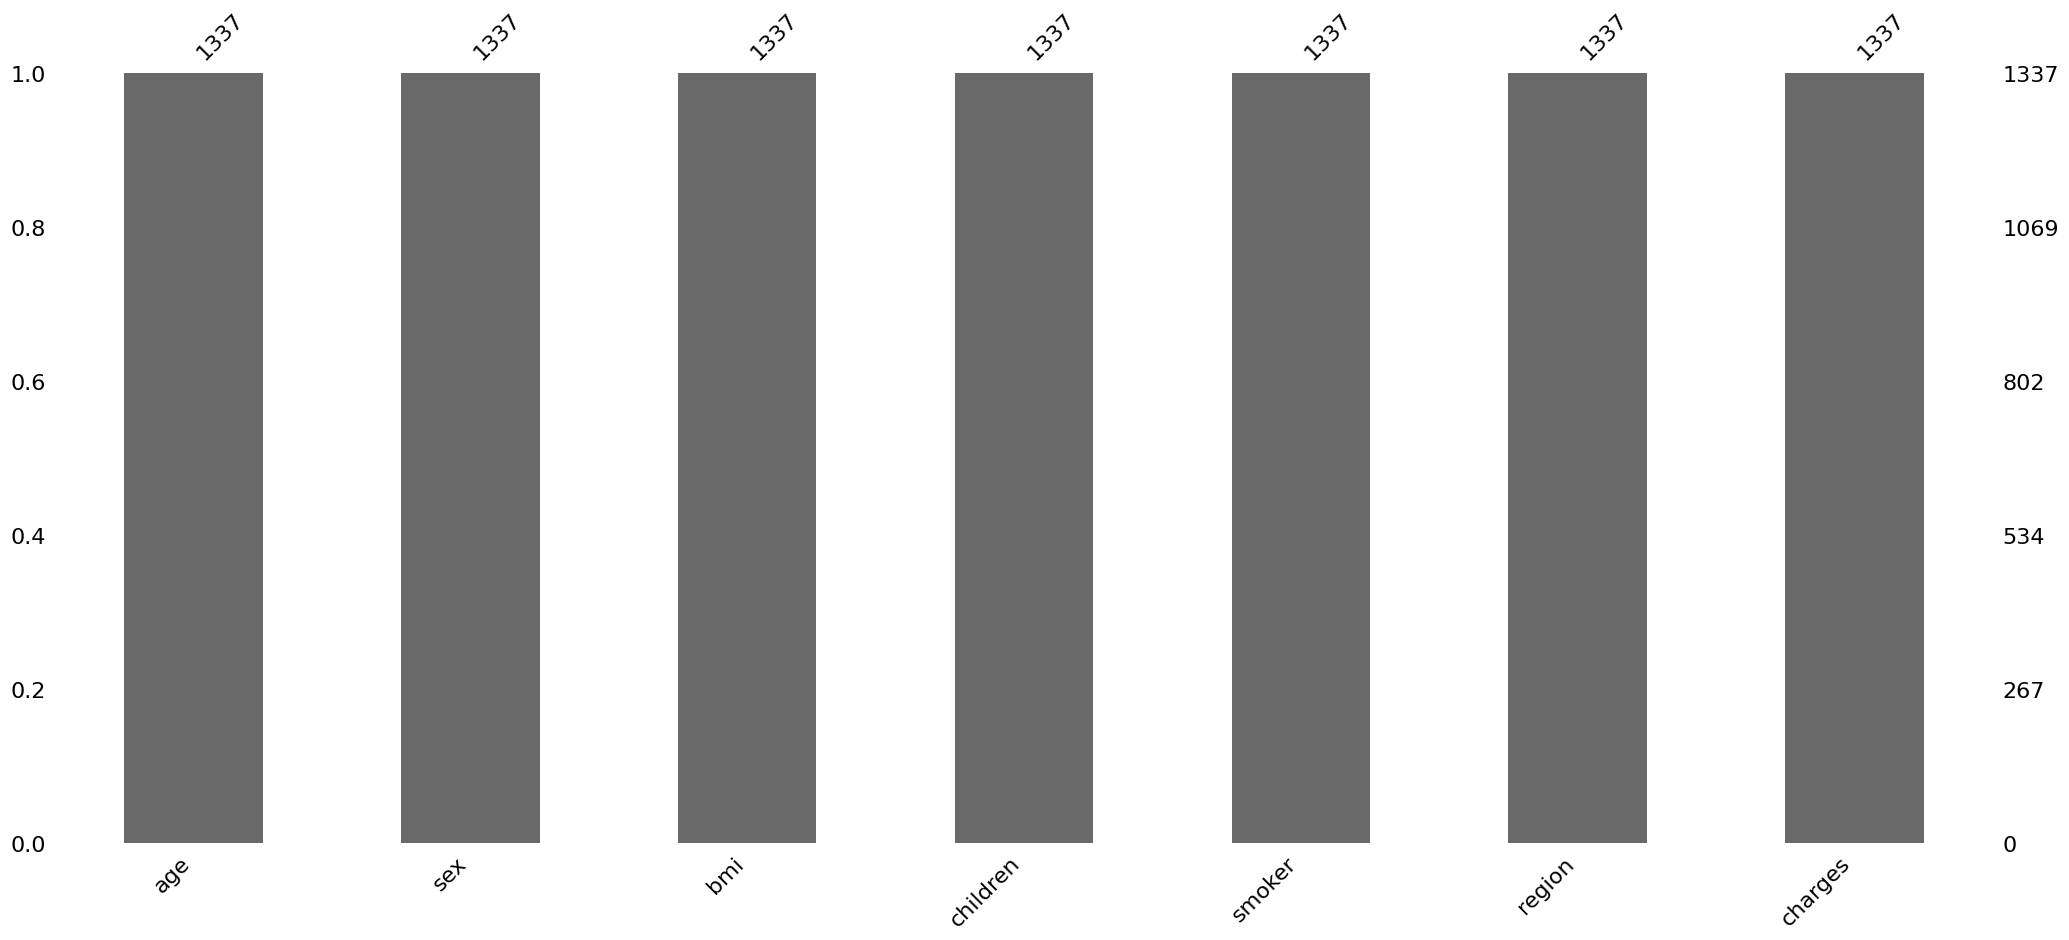

In [12]:
msno.bar(df)

## 2 | Valeurs abhérentes 

<Axes: xlabel='charges', ylabel='Count'>

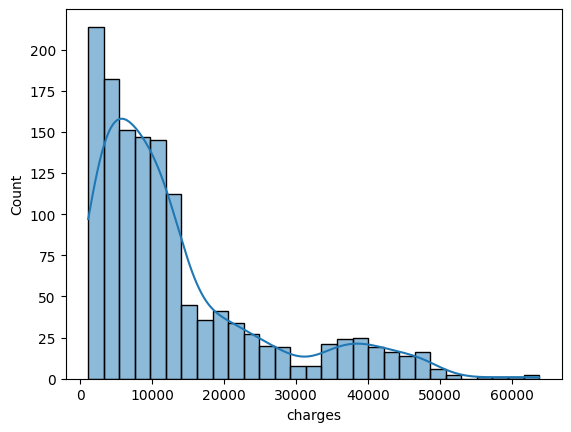

In [13]:
sns.histplot(df['charges'], kde=True)

<Axes: xlabel='charges'>

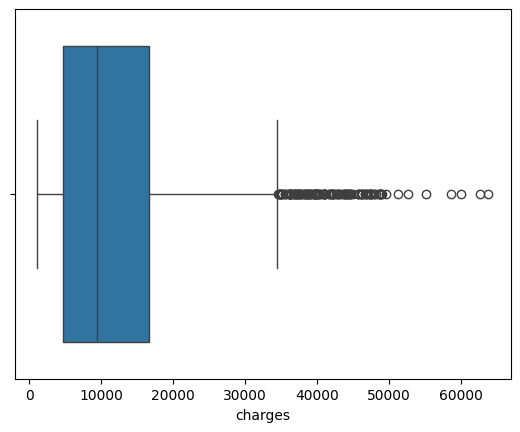

In [14]:
sns.boxplot(x=df["charges"])

<Axes: xlabel='age', ylabel='charges'>

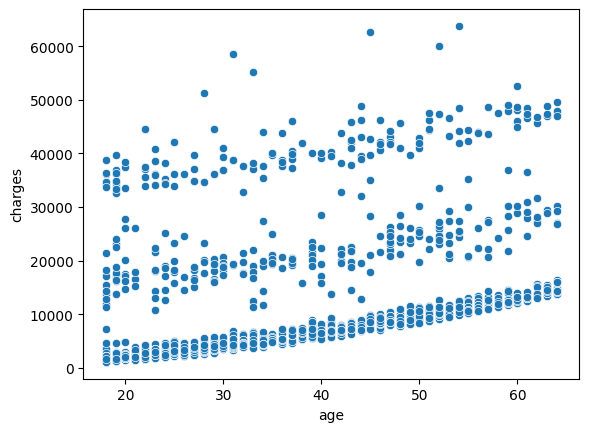

In [15]:
sns.scatterplot(x=df["age"], y=df["charges"])

In [16]:
## PAR ECART INTERQUARTILE (IQR)

""" Etant donné que nos données ne suivent pas une loi normale, on utilse l'IRQ pour déterminer les valeurs abhérentes"""

### Calculer les limites inférieure et supérieure
Q1 = df['charges'].quantile(0.25)  # Premier quartile
Q3 = df['charges'].quantile(0.75)  # Troisième quartile
IQR = Q3 - Q1                      # Intervalle interquartile

borne_inferieure = Q1 - 1.5 * IQR
borne_superieure = Q3 + 1.5 * IQR

### Identification des valeurs aberrantes
charges_outliers = df[(df['charges'] < borne_inferieure) | (df['charges'] > borne_superieure)]
charges_outliers

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309
1301,62,male,30.875,3,yes,northwest,46718.16325
1303,43,male,27.800,0,yes,southwest,37829.72420
1313,19,female,34.700,2,yes,southwest,36397.57600


In [17]:
## L'âge doit être compris entre 18 à 120 ans et être un nombre entier

print(min(df["age"]))
print(max(df["age"]))
print(df["age"].dtype)
print()

"""Les données sur l'âge semblent correctes et n'ont pas l'air de contenir d'erreur"""

## Le BMI humain doit être compris entre 16 et 40
print(min(df["bmi"]))
print(max(df["bmi"]))
print()

"""Il n'existe pas de limites min ou max au BMI cependant un BMI infrieur à 16 est une 'insufficance pondérale sévère' et à plus de 40 c'est 'obésité de classe 3 (sévère)',
nous pourrions donc considérer que nos valeurs min et max ont l'air dans un premier temps d'être abhérentes"""

## Les enfants sont compris en général entre 0 à 5 et être un nombre entier
print(min(df["children"]))
print(max(df["children"]))
print(df["children"].dtype)
print()

"""Pour les données de la colonne 'children', il ne semble pas y avoir de valeurs abhérentes"""

"""Nous allons donc suite à ces observations regarder plus en détails le BMI"""


18
64
int64

15.96
53.13

0
5
int64



'Nous allons donc suite à ces observations regarder plus en détails le BMI'

<Axes: xlabel='bmi'>

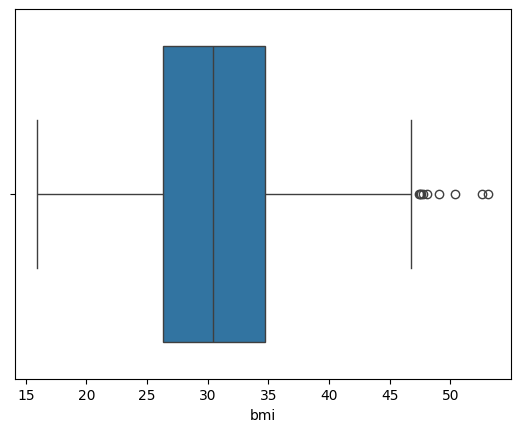

In [18]:
sns.boxplot(x=df['bmi'])

<Axes: xlabel='bmi', ylabel='Count'>

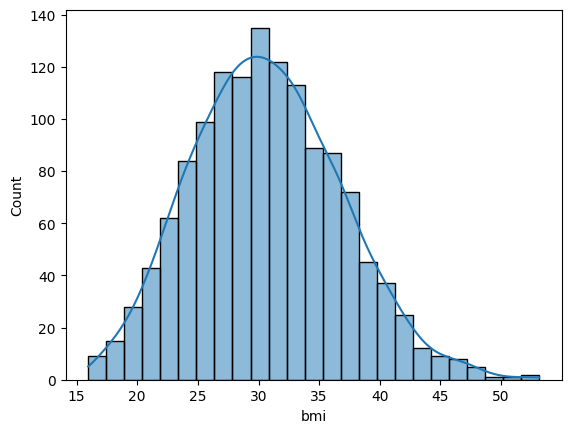

In [19]:
sns.histplot(x=df["bmi"], kde=True)

In [20]:
""" Nos données ont l'air de suivre approximativement une loi normale, on utilisera donc le Z-Score pour trouver les outliers possibles """


from scipy.stats import zscore

# Calcul des Z-scores
df['Z-score'] = zscore(df['bmi'])

# Filtrer les valeurs aberrantes
bmi_outliers = df[df['Z-score'].abs() > 3]
bmi_outliers


,age,sex,bmi,children,smoker,region,charges,Z-score
116,58,male,49.06,0,no,southeast,11381.3254,3.016724
847,23,male,50.38,1,no,southeast,2438.0552,3.233182
1047,22,male,52.58,1,yes,southeast,44501.3982,3.593945
1317,18,male,53.13,0,no,southeast,1163.4627,3.684136


In [21]:
Q1 = df['bmi'].quantile(0.25)  # Premier quartile
Q3 = df['bmi'].quantile(0.75)  # Troisième quartile
IQR = Q3 - Q1                  # Intervalle interquartile

borne_inferieure = Q1 - 1.5 * IQR
borne_superieure = Q3 + 1.5 * IQR

### Identification des valeurs aberrantes
bmi_outliers = df[(df['bmi'] < borne_inferieure) | (df['bmi'] > borne_superieure)]
bmi_outliers.sort_values('bmi')

,age,sex,bmi,children,smoker,region,charges,Z-score
543,54,female,47.41,0,yes,southeast,63770.42801,2.746152
401,47,male,47.52,1,no,southeast,8083.91980,2.764190
860,37,female,47.60,2,yes,southwest,46113.51100,2.777309
1088,52,male,47.74,1,no,southeast,9748.91060,2.800267
286,46,female,48.07,2,no,northeast,9432.92530,2.854381
116,58,male,49.06,0,no,southeast,11381.32540,3.016724
847,23,male,50.38,1,no,southeast,2438.05520,3.233182
1047,22,male,52.58,1,yes,southeast,44501.39820,3.593945
1317,18,male,53.13,0,no,southeast,1163.46270,3.684136


In [22]:
df[df['bmi'] < 16]

,age,sex,bmi,children,smoker,region,charges,Z-score
172,18,male,15.96,0,no,northeast,1694.7964,-2.411119


In [23]:
df[df['bmi'] > 40]

,age,sex,bmi,children,smoker,region,charges,Z-score
14,27,male,42.13,0,yes,southeast,39611.7577,1.880321
18,56,male,40.30,0,no,southwest,10602.3850,1.580232
83,48,female,41.23,4,no,northwest,11033.6617,1.732736
116,58,male,49.06,0,no,southeast,11381.3254,3.016724
170,63,male,41.47,0,no,southeast,13405.3903,1.772092
...,...,...,...,...,...,...,...,...
1240,52,male,41.80,2,yes,southeast,47269.8540,1.826207
1312,34,male,42.90,1,no,southwest,4536.2590,2.006588
1317,18,male,53.13,0,no,southeast,1163.4627,3.684136
1323,42,female,40.37,2,yes,southeast,43896.3763,1.591711


## 3 | Analyse univariée

In [24]:
summary_stats = df.describe().transpose()
summary_stats['median'] = df.select_dtypes('number').median()


summary_stats

,count,mean,std,min,25%,50%,75%,max,median
age,1337.0,3.922214e+01,14.044333,18.000000,27.000000,39.000000,51.000000,64.000000,39.000000
bmi,1337.0,3.066345e+01,6.100468,15.960000,26.290000,30.400000,34.700000,53.130000,30.400000
children,1337.0,1.095737e+00,1.205571,0.000000,0.000000,1.000000,2.000000,5.000000,1.000000
charges,1337.0,1.327912e+04,12110.359656,1121.873900,4746.344000,9386.161300,16657.717450,63770.428010,9386.161300
Z-score,1337.0,-2.285216e-16,1.000374,-2.411119,-0.717173,-0.043202,0.661926,3.684136,-0.043202


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
 7   Z-score   1337 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 94.0+ KB


<Axes: xlabel='charges', ylabel='Count'>

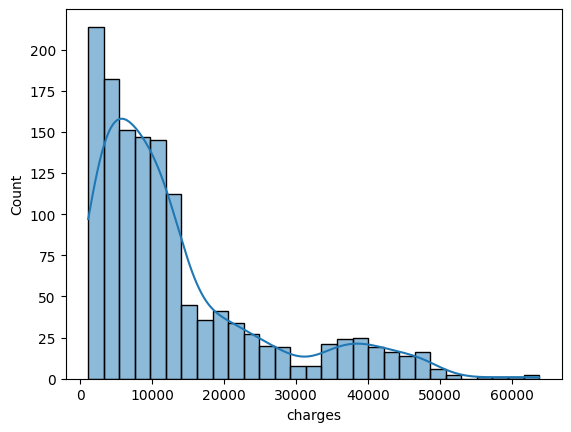

In [26]:
sns.histplot(df['charges'], kde=True)

In [27]:
print(df['region'].value_counts(normalize=True).mul(100).round(2))
print()
print(df['region'].value_counts())

region
southeast    27.23
southwest    24.31
northwest    24.23
northeast    24.23
Name: proportion, dtype: float64

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64


In [28]:
pd.crosstab(df['region'], df['sex'])

sex,female,male
region,,
northeast,161,163
northwest,164,160
southeast,175,189
southwest,162,163


In [29]:
print(df['sex'].value_counts(normalize=True))
print()
print(df['sex'].value_counts())

sex
male      0.504862
female    0.495138
Name: proportion, dtype: float64

sex
male      675
female    662
Name: count, dtype: int64


In [30]:
print(df['children'].value_counts(normalize=True))
print()
print(df['children'].value_counts())

children
0    0.428571
1    0.242334
2    0.179506
3    0.117427
4    0.018699
5    0.013463
Name: proportion, dtype: float64

children
0    573
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64


In [31]:
print(df['smoker'].value_counts(normalize=True))
print()
print(df['smoker'].value_counts())
print()
print(df[['smoker', 'sex']].value_counts(normalize=True))
print()
print(df[['smoker', 'sex']].value_counts())

smoker
no     0.795064
yes    0.204936
Name: proportion, dtype: float64

smoker
no     1063
yes     274
Name: count, dtype: int64

smoker  sex   
no      female    0.409125
        male      0.385939
yes     male      0.118923
        female    0.086013
Name: proportion, dtype: float64

smoker  sex   
no      female    547
        male      516
yes     male      159
        female    115
Name: count, dtype: int64


<Axes: xlabel='charges'>

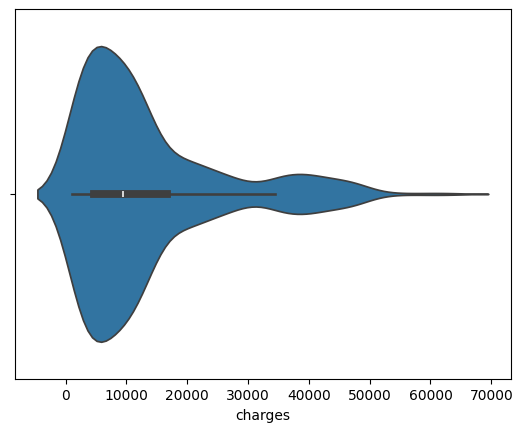

In [32]:
sns.violinplot(x='charges', data=df)

## 4. Analyse Bivariée

In [33]:
df.drop(columns='Z-score', inplace=True)

In [34]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df_encoded = df

df_encoded['sex_encoded'] = encoder.fit_transform(df_encoded['sex'])
df_encoded['region_encoded'] = encoder.fit_transform(df_encoded['region'])
df_encoded['smoker_encoded'] =  encoder.fit_transform(df_encoded['smoker'])

In [35]:
df_encoded = df_encoded[['age', 'sex_encoded', 'bmi', 'children', 'smoker_encoded', 'region_encoded', 'charges']]
df_encoded

,age,sex_encoded,bmi,children,smoker_encoded,region_encoded,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


In [36]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'sex_encoded', 'region_encoded', 'smoker_encoded'],
      dtype='object')

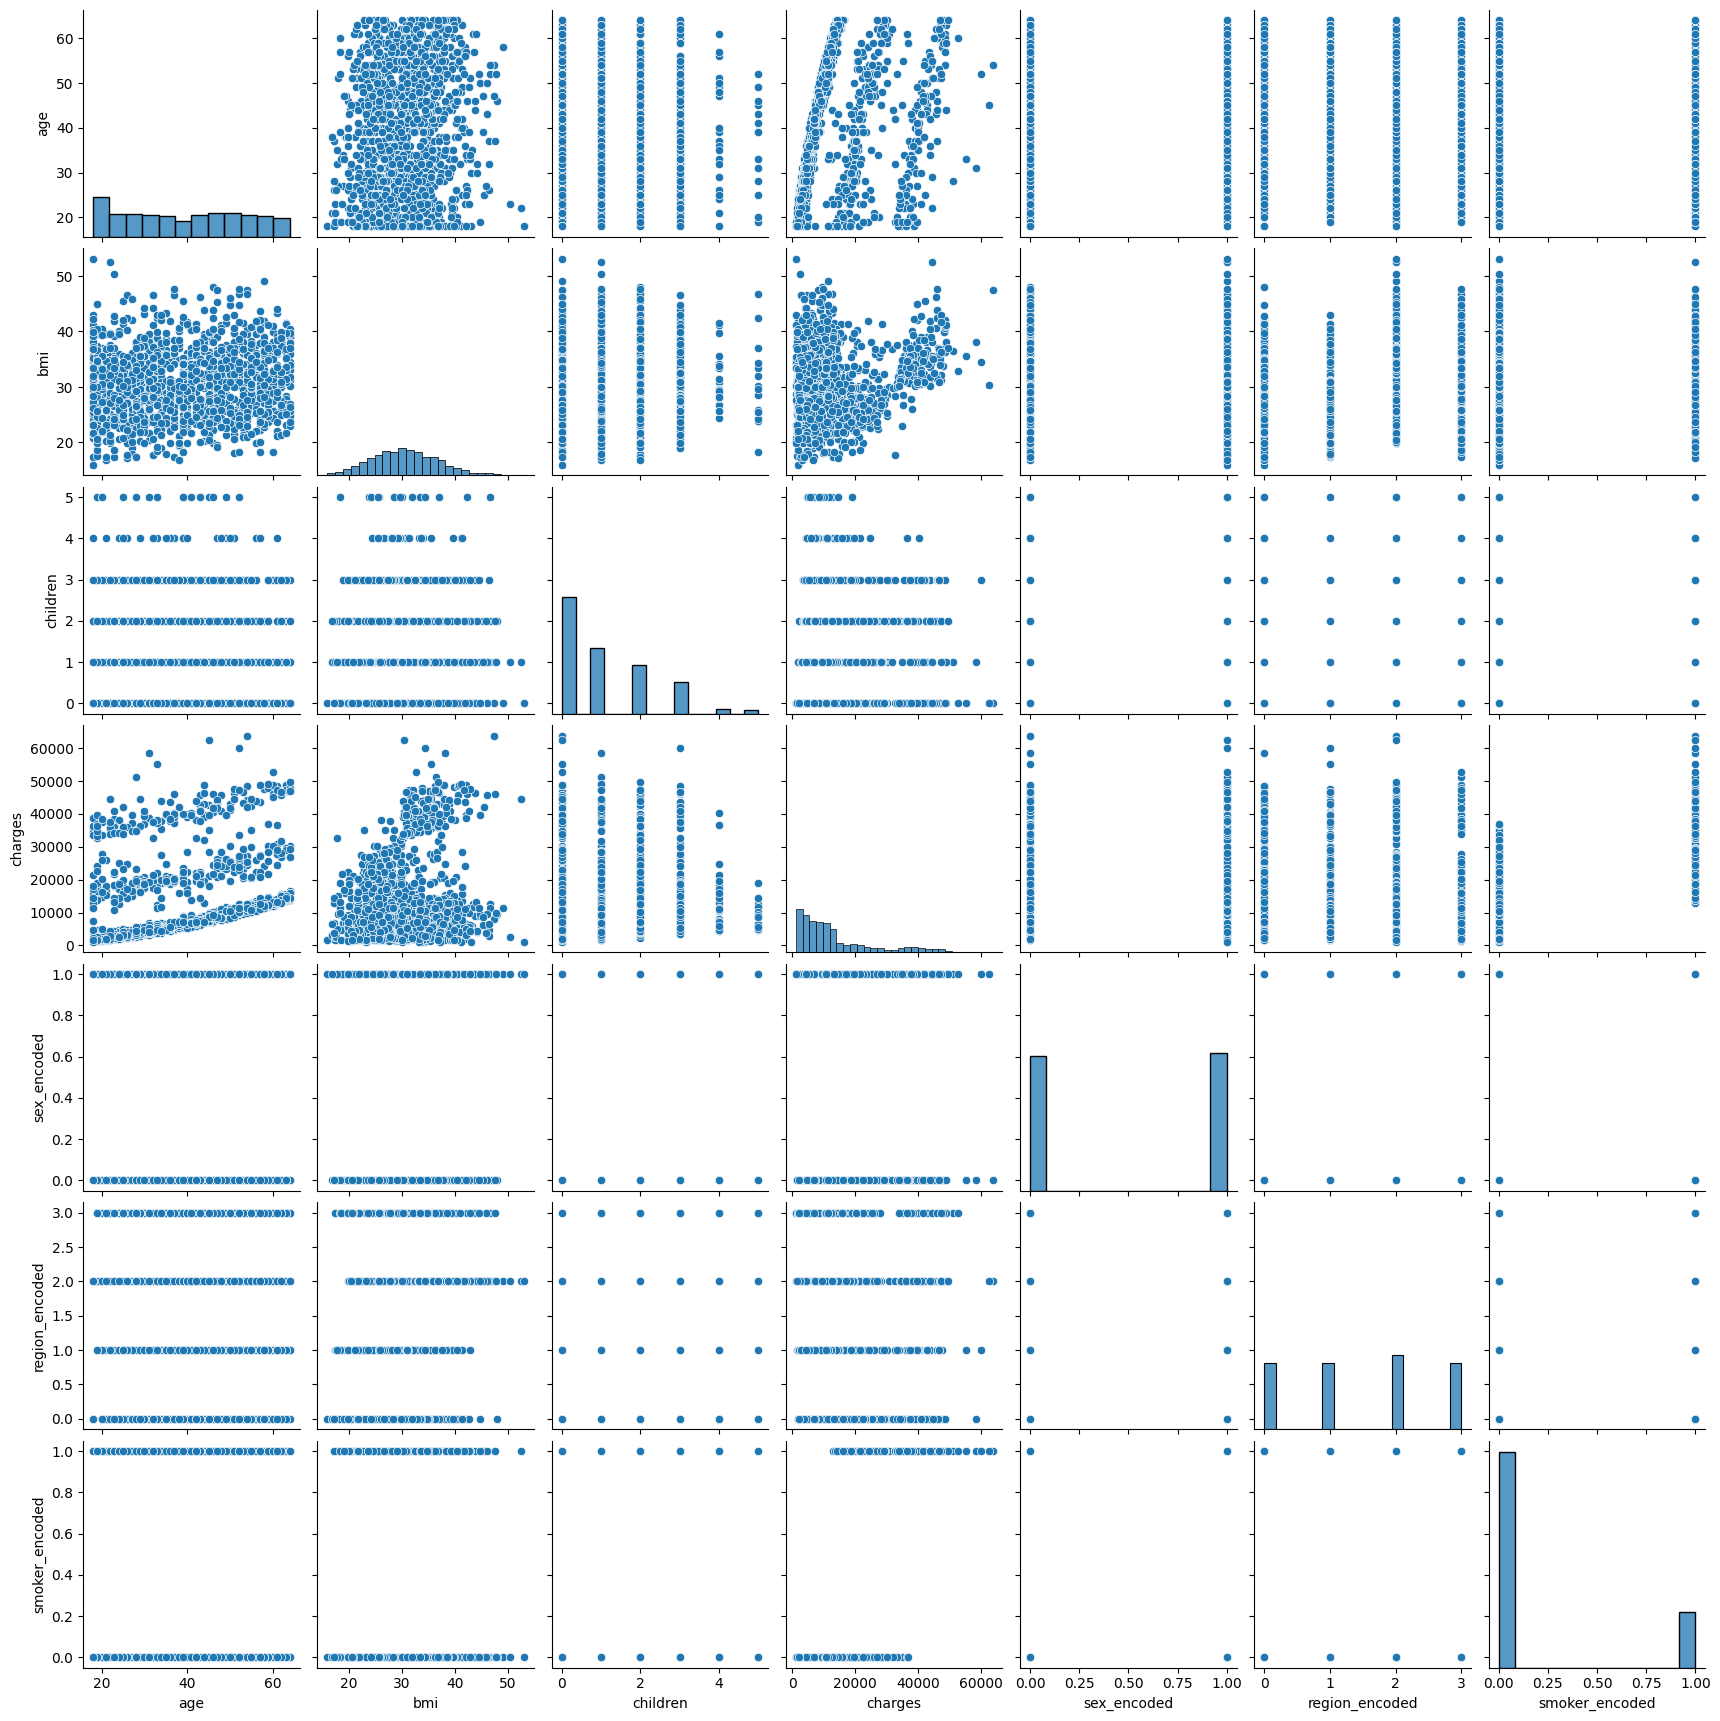

In [37]:
sns.pairplot(df.select_dtypes('number'))

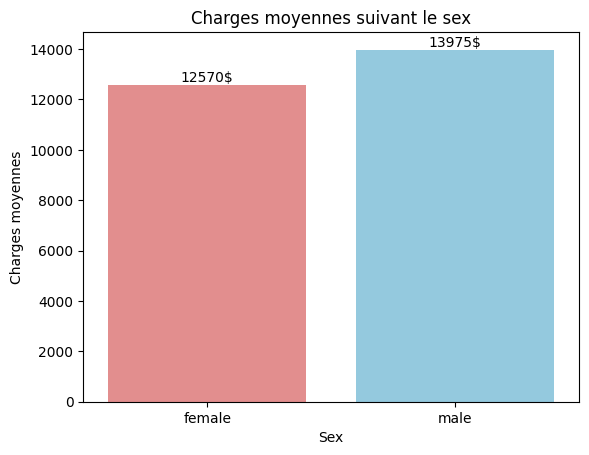

In [38]:
# Relation entre le sex et les charges

sns.barplot(data=df, x='sex', y='charges', estimator='mean', hue='sex', palette=['lightcoral', 'skyblue'], errorbar=None)

# Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

# Personnalisation
plt.xlabel("Sex")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes suivant le sex")
plt.show()



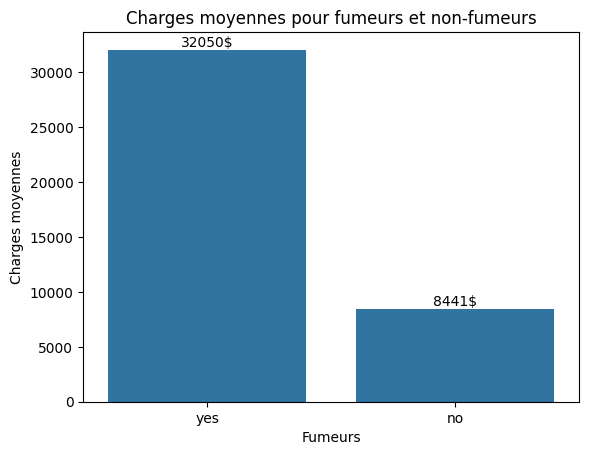

In [39]:
# Relation entre le fait de fumer et les charges

## BarPlot
sns.barplot(data=df, x='smoker', y='charges', estimator='mean', errorbar=None)

## Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

#"" Personnalisation
plt.xlabel("Fumeurs")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes pour fumeurs et non-fumeurs")
plt.show()

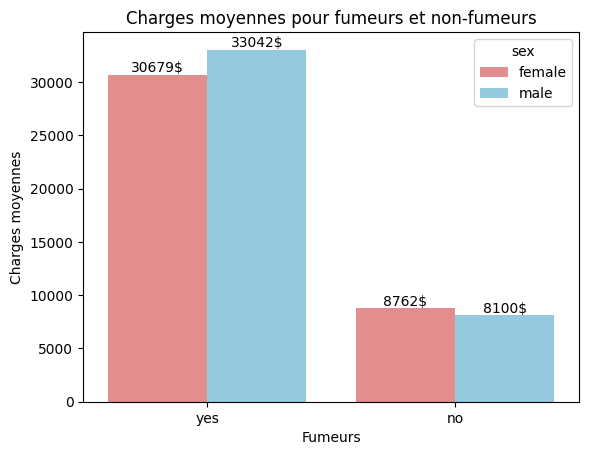

In [40]:
# Relation entre le fait de fumer et les charges et le sex

## BarPlot
sns.barplot(data=df, x='smoker', y='charges', estimator='mean', hue='sex', palette=['lightcoral', 'skyblue'], errorbar=None)

## Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

## Personnalisation
plt.xlabel("Fumeurs")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes pour fumeurs et non-fumeurs")
plt.show()

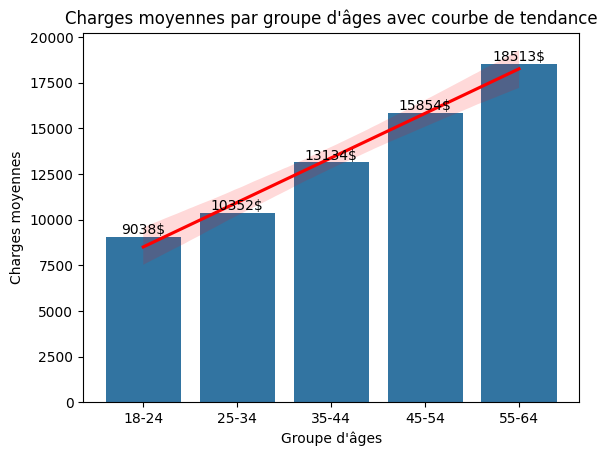

In [41]:
# Relation entre l'âge et les charges

df['age_group'] = pd.cut(
    df['age'],
    bins=[17, 24, 34, 44, 54, 64],                             
    labels=['18-24', '25-34', '35-44', '45-54', '55-64']
)

age_group_mapping = {'18-24': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55-64': 4}
df['age_group_numeric'] = df['age_group'].map(age_group_mapping)

# BarPlot
sns.barplot(data=df, x='age_group', y='charges', estimator='mean', errorbar=None)

# Courbe de tendance avec regplot (régression linéaire)
sns.regplot(data=df, x='age_group_numeric', y='charges', scatter=False, color='red')

# Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

# Personnalisation
plt.xlabel("Groupe d'âges")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes par groupe d'âges avec courbe de tendance")
plt.show()

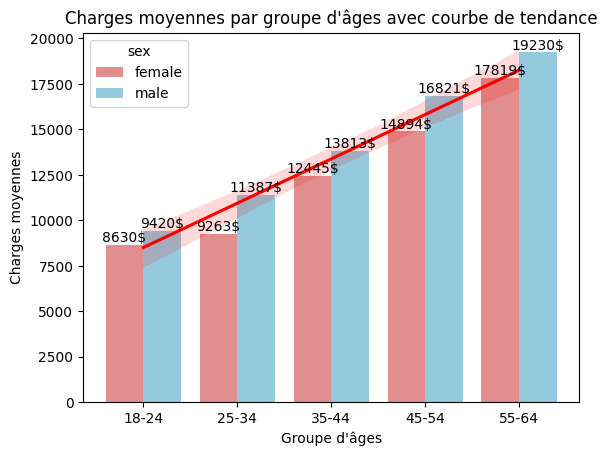

In [42]:
# Relation entre l'âge et les charges et le sex
df['age_group'] = pd.cut(
    df['age'],
    bins=[17, 24, 34, 44, 54, 64],                             
    labels=['18-24', '25-34', '35-44', '45-54', '55-64']
)

age_group_mapping = {'18-24': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55-64': 4}
df['age_group_numeric'] = df['age_group'].map(age_group_mapping)

# BarPlot
sns.barplot(data=df, x='age_group', y='charges', hue='sex', estimator='mean', palette=['lightcoral', 'skyblue'], errorbar=None)

# Courbe de tendance avec regplot (régression linéaire)
sns.regplot(data=df, x='age_group_numeric', y='charges', scatter=False, color='red')

# Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

# Personnalisation
plt.xlabel("Groupe d'âges")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes par groupe d'âges avec courbe de tendance")
plt.show()


In [43]:
pd.pivot_table(data=df, 
               values='charges', 
               index='age_group',   
               aggfunc=['count', 'mean', 'median', 'std'],
               observed=True
               ).round(2)

,count,mean,median,std
,charges,charges,charges,charges
age_group,,,,
18-24,277,9037.95,2457.50,11808.09
25-34,271,10352.39,4718.20,11424.01
35-44,260,13134.17,7205.60,11788.98
45-54,287,15853.93,10115.01,11725.30
55-64,242,18513.28,13226.77,11352.69


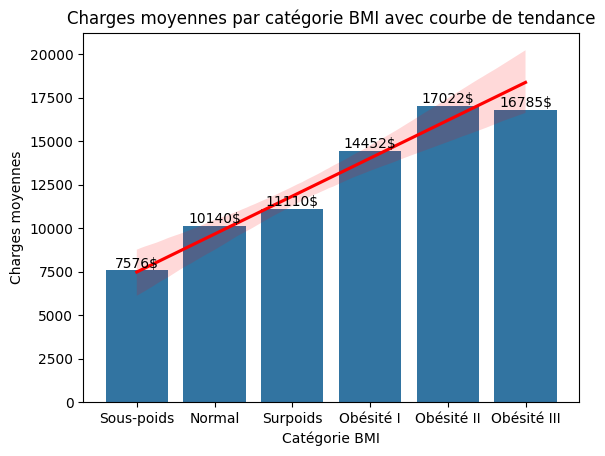

In [44]:
# Relation entre le BMI et les charges

## Création des catégories de BMI
def bmi_category(bmi):
    if bmi < 18:
        return "Sous-poids"
    elif bmi < 24.5:
        return "Normal"
    elif bmi < 30:
        return "Surpoids"
    elif bmi < 35:
        return "Obésité I"
    elif bmi < 40:
        return "Obésité II"
    else:
        return "Obésité III"

df["bmi_cat"] = df["bmi"].apply(bmi_category)

## Mapping de BMI
bmi_mapping = {'Sous-poids': 0,'Normal': 1, 'Surpoids': 2, 'Obésité I': 3, 'Obésité II': 4, 'Obésité III': 5}

df['bmi_cat_numeric'] = df['bmi_cat'].map(bmi_mapping)

## BarPlot
sns.barplot(data=df, x='bmi_cat', y='charges', estimator="mean", errorbar=None, order=bmi_mapping.keys())

## Courbe de tendance avec regplot (régression linéaire)
sns.regplot(data=df, x='bmi_cat_numeric', y='charges', scatter=False, color='red')

## Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

## Personnalisation
plt.xlabel("Catégorie BMI")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes par catégorie BMI avec courbe de tendance")
plt.show()


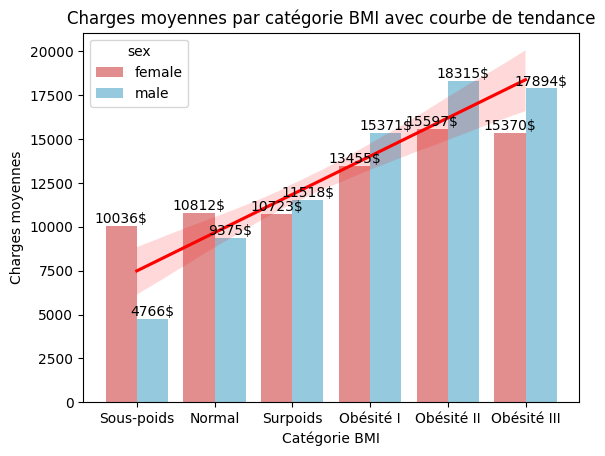

In [45]:
## Création des catégories de BMI
def bmi_category(bmi):
    if bmi < 18:
        return "Sous-poids"
    elif bmi < 24.5:
        return "Normal"
    elif bmi < 30:
        return "Surpoids"
    elif bmi < 35:
        return "Obésité I"
    elif bmi < 40:
        return "Obésité II"
    else:
        return "Obésité III"

df["bmi_cat"] = df["bmi"].apply(bmi_category)

## Mapping de BMI
bmi_mapping = {'Sous-poids': 0,'Normal': 1, 'Surpoids': 2, 'Obésité I': 3, 'Obésité II': 4, 'Obésité III': 5}

df['bmi_cat_numeric'] = df['bmi_cat'].map(bmi_mapping)

## BarPlot
sns.barplot(data=df, x='bmi_cat', y='charges', estimator="mean", errorbar=None, hue='sex', palette=['lightcoral', 'skyblue'], order=bmi_mapping.keys())

## Courbe de tendance avec regplot (régression linéaire)
sns.regplot(data=df, x='bmi_cat_numeric', y='charges', scatter=False, color='red')

## Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

## Personnalisation
plt.xlabel("Catégorie BMI")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes par catégorie BMI avec courbe de tendance")
plt.show()


In [46]:
pd.pivot_table(data=df, 
               values='charges',  # On peut utiliser n'importe quelle colonne ici
               index='bmi_cat',   # C'est la colonne pour laquelle on veut les catégories
               aggfunc=['count', 'mean', 'median', 'std'],
               ).reindex(bmi_mapping).round(2)



,count,mean,median,std
,charges,charges,charges,charges
bmi_cat,,,,
Sous-poids,15,7576.42,3732.63,8370.27
Normal,203,10139.76,8603.82,7246.19
Surpoids,413,11109.70,8823.28,8079.05
Obésité I,390,14452.44,9573.46,13575.10
Obésité II,225,17022.26,11264.54,15171.51
Obésité III,91,16784.62,9748.91,16658.19


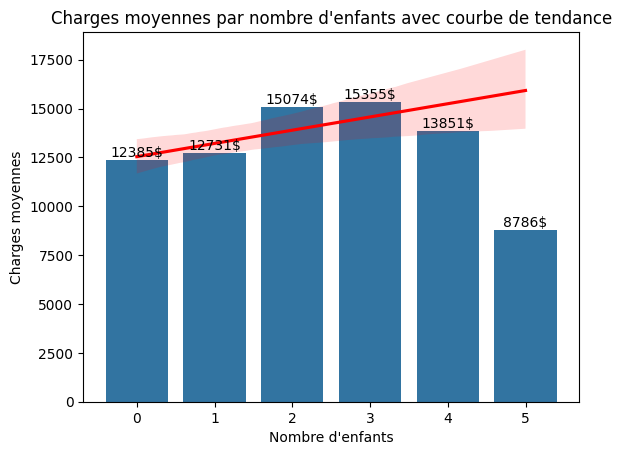

In [47]:
# Relation entre le nombre d'enfants et les charges

## BarPlot
sns.barplot(data=df, x='children', y='charges', errorbar=None)
sns.regplot(data=df, x='children', y='charges', scatter=False, color='red')

## Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

## Personnalisation
plt.xlabel("Nombre d'enfants")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes par nombre d'enfants avec courbe de tendance")
plt.show()

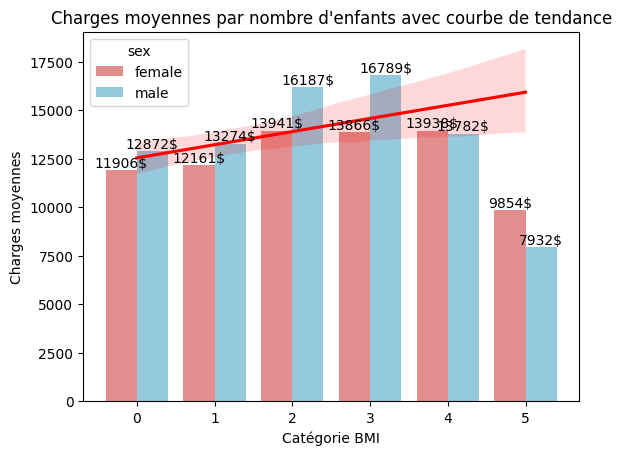

In [48]:
# BarPlot
sns.barplot(data=df, x='children', y='charges', estimator="mean", hue='sex', palette=['lightcoral', 'skyblue'], errorbar=None)
sns.regplot(data=df, x='children', y='charges', scatter=False, color='red')

## Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

# Personnalisation
plt.xlabel("Catégorie BMI")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes par nombre d'enfants avec courbe de tendance")
plt.show()

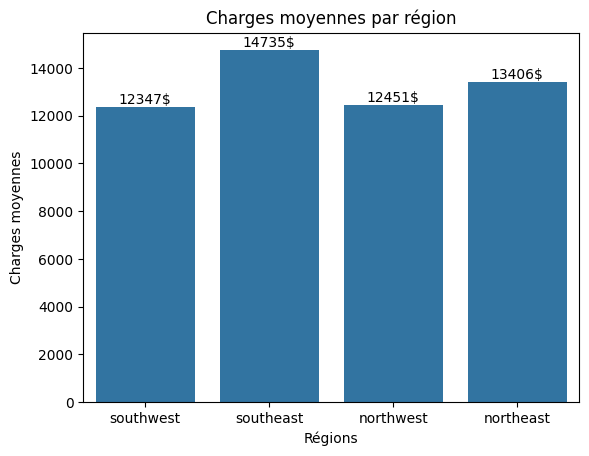

In [49]:
# Relation entre le nombre d'enfants et les charges

## BarPlot
sns.barplot(data=df, x='region', y='charges', estimator='mean', errorbar=None)

## Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

## Personnalisation
plt.xlabel("Régions")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes par région")
plt.show()

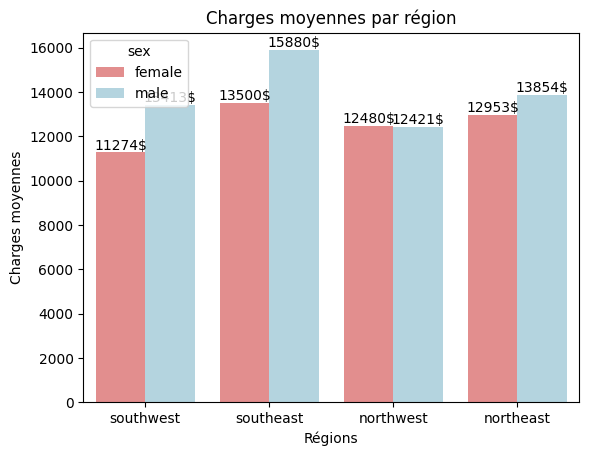

In [50]:
# Relation entre le nombre d'enfants et les charges

## BarPlot
sns.barplot(data=df, x='region', y='charges', estimator='mean', hue='sex', palette=['lightcoral', 'lightblue'], errorbar=None)

## Annotations
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f$')

## Personnalisation
plt.xlabel("Régions")
plt.ylabel("Charges moyennes")
plt.title("Charges moyennes par région")
plt.show()

In [51]:
pd.pivot_table(data=df, 
               values='charges',
               index='children',
               aggfunc=['count', 'mean', 'median', 'std']
               ).round(2)

,count,mean,median,std
,charges,charges,charges,charges
children,,,,
0,573,12384.70,9863.47,12025.42
1,324,12731.17,8483.87,11823.63
2,240,15073.56,9264.98,12891.37
3,157,15355.32,10600.55,12330.87
4,25,13850.66,11033.66,9139.22
5,18,8786.04,8589.57,3808.44


## 5 | Corrélations

<Axes: >

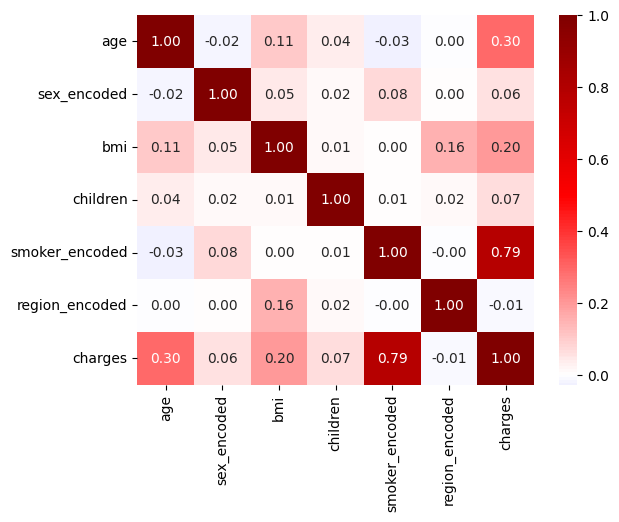

In [52]:
sns.heatmap(df_encoded.select_dtypes('number').corr(), annot = True, fmt='.2f', cmap='seismic', center=0)

In [53]:
df_encoded

,age,sex_encoded,bmi,children,smoker_encoded,region_encoded,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


In [54]:
df_encoded_bis = pd.get_dummies(df[['age', 'sex_encoded', 'bmi', 'region', 'smoker_encoded', 'charges']], columns=['region'], dtype=int)

df_encoded_bis

,age,sex_encoded,bmi,smoker_encoded,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,1,16884.92400,0,0,0,1
1,18,1,33.770,0,1725.55230,0,0,1,0
2,28,1,33.000,0,4449.46200,0,0,1,0
3,33,1,22.705,0,21984.47061,0,1,0,0
4,32,1,28.880,0,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,0,10600.54830,0,1,0,0
1334,18,0,31.920,0,2205.98080,1,0,0,0
1335,18,0,36.850,0,1629.83350,0,0,1,0
1336,21,0,25.800,0,2007.94500,0,0,0,1


## 6 | Tests

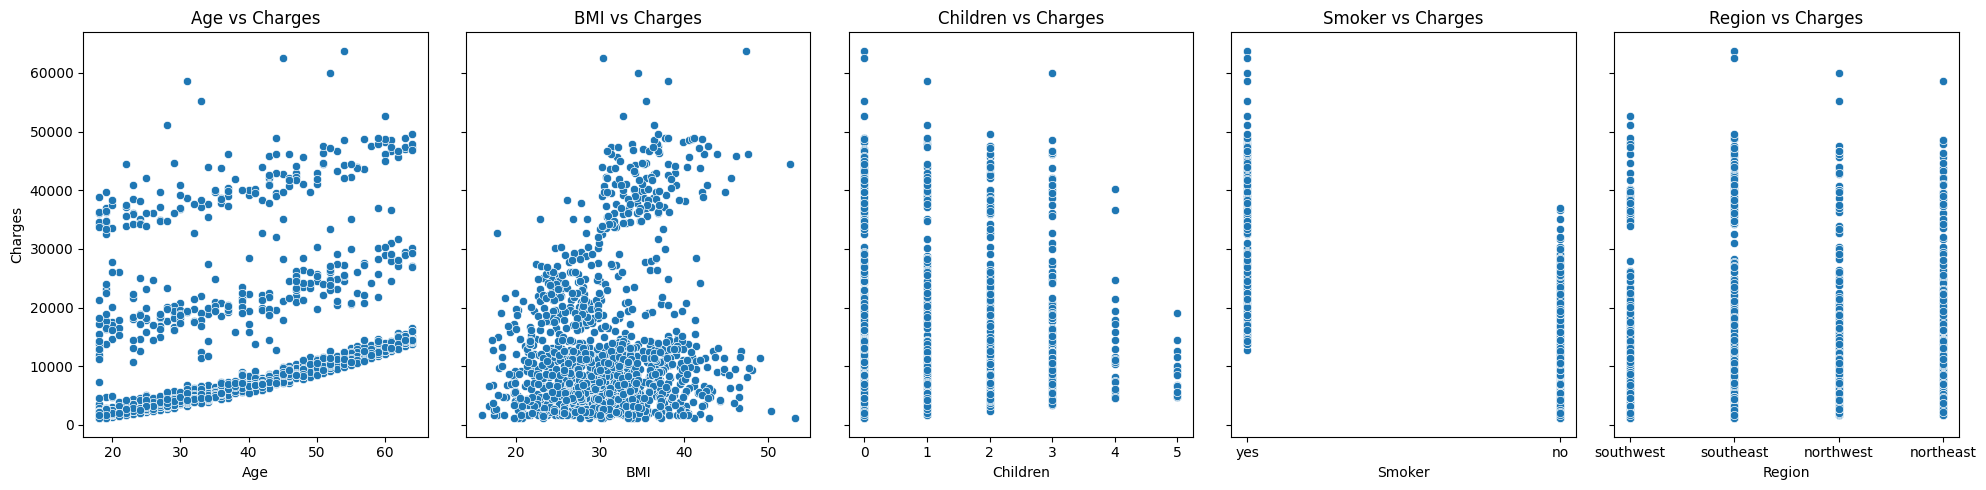

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer une figure avec des sous-graphiques côte à côte
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

# Graphique 1 : Relation entre l'âge et les charges
sns.scatterplot(data=df, x='age', y='charges', ax=axes[0])
axes[0].set_title("Age vs Charges")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Charges")

# Graphique 2 : Relation entre l'IMC et les charges
sns.scatterplot(data=df, x='bmi', y='charges', ax=axes[1])
axes[1].set_title("BMI vs Charges")
axes[1].set_xlabel("BMI")
axes[1].set_ylabel("")

# Graphique 3 : Relation entre le nombre d'enfants et les charges
sns.scatterplot(data=df, x='children', y='charges', ax=axes[2])
axes[2].set_title("Children vs Charges")
axes[2].set_xlabel("Children")
axes[2].set_ylabel("")

# Graphique 4 : Relation entre le statut de fumeur et les charges
sns.scatterplot(data=df, x='smoker', y='charges', ax=axes[3])
axes[3].set_title("Smoker vs Charges")
axes[3].set_xlabel("Smoker")
axes[3].set_ylabel("")

# Graphique 5 : Relation entre le statut de fumeur et les charges
sns.scatterplot(data=df, x='region', y='charges', ax=axes[4])
axes[4].set_title("Region vs Charges")
axes[4].set_xlabel("Region")
axes[4].set_ylabel("")

# Ajustement de l'espacement entre les graphiques
plt.tight_layout()

# Affichage
plt.show()


### Analyse Univariée

In [56]:
# Âge

print(smf.ols('charges ~ age', data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     130.4
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           6.98e-29
Time:                        16:57:32   Log-Likelihood:                -14405.
No. Observations:                1337   AIC:                         2.881e+04
Df Residuals:                    1335   BIC:                         2.882e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3190.0217    938.396      3.399      0.0

Le modèle n'explique qu'environ 8.9 % de la variance des charges, ce qui est très faible. Cela signifie que d'autres variables (comme bmi, smoker, ou sex) sont probablement importantes pour expliquer les variations des charges.

Bien que age ait un effet significatif sur les charges, cet effet est relativement faible (257.23 unités monétaires par an).

Les résidus ne sont pas normalement distribués, ce qui pourrait affecter la validité des tests statistiques. Cela peut être dû à l'absence d'autres variables importantes dans le modèle.

In [57]:
# BMI

print(smf.ols('charges ~ bmi', data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     54.70
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           2.47e-13
Time:                        16:57:32   Log-Likelihood:                -14440.
No. Observations:                1337   AIC:                         2.888e+04
Df Residuals:                    1335   BIC:                         2.889e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1202.1404   1664.857      0.722      0.4

R² = 0.039 : 3.9 % de la variabilité des charges est expliquée par l’IMC.
Le coefficient (393.86) montre qu’une augmentation d’une unité de l’IMC est associée à une augmentation moyenne de 393.86 unités monétaires des charges.

Le test global du modèle (F−statistic = 54.70) est également significatif (P=2.47×10^(−13)), confirmant que bmi apporte une information utile pour expliquer charges.

Bien que bmi ait un effet significatif sur charges, il ne suffit pas à expliquer les variations importantes des coûts médicaux. 

In [58]:
# Children

print(smf.ols('charges ~ children', data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     6.090
Date:                Wed, 08 Jan 2025   Prob (F-statistic):             0.0137
Time:                        16:57:33   Log-Likelihood:                -14464.
No. Observations:                1337   AIC:                         2.893e+04
Df Residuals:                    1335   BIC:                         2.894e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.254e+04    446.786     28.061      0.0

R² = 0.005 : Cela signifie que seulement 0,5 % de la variation des charges médicales est expliquée par le nombre d'enfants. Un R² aussi faible suggère que le modèle n'explique pratiquement rien de la variation des charges.

In [59]:
# Regions

print(smf.ols('charges ~ region', data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.926
Date:                Wed, 08 Jan 2025   Prob (F-statistic):             0.0328
Time:                        16:57:33   Log-Likelihood:                -14462.
No. Observations:                1337   AIC:                         2.893e+04
Df Residuals:                    1333   BIC:                         2.895e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.341e+04    

R² = 0.007 : Cela suggère que les variables indépendantes incluses dans le modèle n'ont qu'une influence marginale sur charges.

Variables catégorielles "region" :
"northwest" : Le coefficient est de -955,54, mais avec une valeur p de 0,314, ce qui indique que cette variable n'a pas d'effet statistiquement significatif sur "charges".
"southeast" : Le coefficient est de 1 329,03, avec une valeur p de 0,150, suggérant également un effet non significatif.
"southwest" : Le coefficient est de -1 059,45, avec une valeur p de 0,264, indiquant un effet non significatif.
Aucune des variables "region" n'a d'effet statistiquement significatif sur "charges" dans ce modèle.

Autres statistiques :

F-statistic : La valeur est de 2,926 avec une valeur p de 0,0328, indiquant que le modèle dans son ensemble est significatif.bien que le modèle global soit statistiquement significatif, les variables régionales incluses n'ont pas d'effet significatif sur charges. De plus, les résidus ne suivent pas une distribution normale, ce qui pourrait affecter la validité des résultats.

In [60]:
# Smoker

print(smf.ols('charges ~ smoker', data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     2176.
Date:                Wed, 08 Jan 2025   Prob (F-statistic):          1.41e-282
Time:                        16:57:33   Log-Likelihood:                -13820.
No. Observations:                1337   AIC:                         2.764e+04
Df Residuals:                    1335   BIC:                         2.766e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      8440.6603    229.137     36.837

Cela signifie que 62 % de la variation des charges médicales est expliquée par la variable explicative "smoker" (le statut de fumeur). Ce résultat indique une bonne capacité explicative du modèle. Un R² aussi élevé montre que le statut de fumeur a un impact significatif sur les charges médicales.

smoker[T.yes] = 23 610,00 : Cela signifie que les charges médicales sont en moyenne 23 610 unités monétaires plus élevées pour un fumeur comparé à un non-fumeur.

F-statistic = 2176 et p-value associée = 1.41e-282 : Le test F est très significatif (p-value extrêmement faible), ce qui confirme que le modèle dans son ensemble est bien ajusté et que la variable explicative "smoker" contribue de manière importante à la prédiction des charges.

## Analyse Multivariée

In [61]:
df_encoded

,age,sex_encoded,bmi,children,smoker_encoded,region_encoded,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


In [62]:
X = df_encoded.drop(columns='charges')
y = df['charges']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     667.0
Date:                Wed, 08 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:57:33   Log-Likelihood:                -13539.
No. Observations:                1337   AIC:                         2.709e+04
Df Residuals:                    1330   BIC:                         2.713e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.181e+04    955.719    -12.

Les résultats de la régression linéaire multiple indiquent que le modèle explique environ 75,1 % de la variance des charges médicales, ce qui est relativement élevé. Les variables indépendantes significatives comprennent l'âge, l'indice de masse corporelle (IMC), le nombre d'enfants, le statut de fumeur et la région. En revanche, le sexe n'a pas d'effet statistiquement significatif sur les charges médicales dans ce modèle.

R² = 0,751 : Le modèle explique environ 75,1% de la variance de la variable dépendante "charges". Cela signifie que le modèle est relativement performant.
Adj. R² = 0,749 : L'ajustement prend en compte le nombre de variables explicatives, ce qui reste très bon. L'ajustement montre qu'il y a très peu de perte de performance lorsque l'on ajuste pour la complexité du modèle.

F-statistic = 667,0 avec une p-value proche de 0 : Cela signifie que le modèle dans son ensemble est très significatif et que la probabilité que les résultats soient dus au hasard est extrêmement faible.


* **age** : Le coefficient est 257,20, avec une p-value = 0,000. Cela montre que l'âge a un effet statistiquement significatif sur les charges (une augmentation de l'âge de 1 an est associée à une augmentation de 257,20 unités des charges).

* **sex_encoded** : Le coefficient est de -129,40, mais avec une p-value = 0,698. Cela indique que le sexe n'a pas un effet significatif sur les charges.

* **bmi** : Le coefficient est 332,60, avec une p-value = 0,000. Cela montre que le BMI a un impact statistiquement significatif sur les charges (une augmentation du BMI de 1 unité est associée à une augmentation de 332,60 unités des charges).

* **children** : Le coefficient est 478,77, avec une p-value = 0,001. Cela montre qu'avoir des enfants a un effet positif et significatif sur les charges (chaque enfant supplémentaire est associé à une augmentation de 478,77 unités des charges).

* **smoker_encoded** : Le coefficient est de 23 820, avec une p-value = 0,000. Cela montre qu'être fumeur a un impact majeur et significatif sur les charges.

* **region_encoded** : Le coefficient est de -354,01, avec une p-value = 0,020. Cela montre que la région a un effet modéré mais significatif sur les charges (certaines régions entraînent une réduction ou une augmentation des charges par rapport à la moyenne).

In [63]:
df_encoded_bis

,age,sex_encoded,bmi,smoker_encoded,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,1,16884.92400,0,0,0,1
1,18,1,33.770,0,1725.55230,0,0,1,0
2,28,1,33.000,0,4449.46200,0,0,1,0
3,33,1,22.705,0,21984.47061,0,1,0,0
4,32,1,28.880,0,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,0,10600.54830,0,1,0,0
1334,18,0,31.920,0,2205.98080,1,0,0,0
1335,18,0,36.850,0,1629.83350,0,0,1,0
1336,21,0,25.800,0,2007.94500,0,0,0,1


In [78]:
df = pd.read_csv('dataset_insurance.csv')
df


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [79]:
encoder = LabelEncoder()

df_encoded_dummies = df

df_encoded_dummies['sex_encoded'] = encoder.fit_transform(df_encoded_dummies['sex'])
df_encoded_dummies['region_encoded'] = encoder.fit_transform(df_encoded_dummies['region'])
df_encoded_dummies['smoker_encoded'] =  encoder.fit_transform(df_encoded_dummies['smoker'])

In [80]:
df_encoded_dummies

,age,sex,bmi,children,smoker,region,charges,sex_encoded,region_encoded,smoker_encoded
0,19,female,27.900,0,yes,southwest,16884.92400,0,3,1
1,18,male,33.770,1,no,southeast,1725.55230,1,2,0
2,28,male,33.000,3,no,southeast,4449.46200,1,2,0
3,33,male,22.705,0,no,northwest,21984.47061,1,1,0
4,32,male,28.880,0,no,northwest,3866.85520,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1,1,0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,0
1335,18,female,36.850,0,no,southeast,1629.83350,0,2,0
1336,21,female,25.800,0,no,southwest,2007.94500,0,3,0


In [77]:
df = pd.get_dummies(df, columns=['smok', '']drop_first=True, dtype=int)
df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,True,False,True,False,False
1334,18,31.920,0,2205.98080,False,False,False,False,False
1335,18,36.850,0,1629.83350,False,False,False,True,False
1336,21,25.800,0,2007.94500,False,False,False,False,True
